## Exploring CIFAR-10  dataset with Keras

The aim of this notebook is to load a TinyVGGNet model trained on the CIFAR-10 dataset and visualise the weights and the feature maps for some sample images. 

In [2]:
# The usual imports
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimage
%matplotlib inline
plt.rcParams['figure.figsize']=[10,10]

# Keras specific imports
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.utils import np_utils

Using Theano backend.


### Tiny VGG Net Model

The tinyVGG module contains the architecture and implementation of 
a scaled down VGGNet model. This model is thus named tinyVGGNet.

In accordance with the full-scale model, all convolutions are 
performed using F=3 and S=1. Additionally, max-pooling is performed with F=2 and a stride of S=1. This is done so that the Conv filters are responsible for extracting features and the pooling layers are responsible for downsampling and retaining only the most important features. 

<em>The architecture is shown below. Look at model.py script under the tinyVGG folder for code.</em><br>

In [3]:
# display the model
from IPython.core.display import Image 
Image(filename='deepnet.png')

In [4]:
# importing model
from tinyVGG.model import tinyVGGNet
# load some utilities for making dataset work nice with Keras
from helpers.utils import genmplImg, load_CIFAR10, oneHot, reformat, unpickle, reformat_wts

load_wts = True
model = tinyVGGNet.build(width=32,height=32,depth=3,classes=10)

if load_wts:
    model.load_weights('./weights-improvement-11-0.75.hdf5')

# print a summary of the model
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 34, 34)     0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 32, 32)    448         zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 16, 34, 34)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 32, 32)    2320        zeropadding2d_2[0][0]            
___________________________________________________________________________________________

### Data I/O

We use the utility provided by Stanford's cs231n assignments to load up the dataset. The Dataset is loaded up in the format of (batch_size, 32, 32, 3) but keras model fitting routines expect an input size of (batch_size, 3, 32, 32), hence we use the reformat function in helpers/utils.py to correct the data format.

Also, Keras uses one-hot encoding i.e (0,0,1,0,0,0,0,0,0,0) for the data labels. The utility <em>np_utils.to_categorical</em> provided by Keras does the job for us. This is wrapped in a convenience function oneHot(dat).  

In [5]:
X_train, y_train, X_test, y_test = load_CIFAR10('./cifar-10-batches-py/')
labels = unpickle('./cifar-10-batches-py/batches.meta')['label_names'] 

# Reformatting dataset to size (batch, 3, 32, 32)
trainData = reformat(X_train)
testData  = reformat(X_test)

trainLabels = oneHot(y_train)
testLabels  = oneHot(y_test)

print trainData.shape,'\n' , testData.shape,'\n' , trainLabels.shape,'\n' , testLabels.shape
print 'Labels-> ',labels

(50000, 3, 32, 32) 
(10000, 3, 32, 32) 
(50000, 10) 
(10000, 10)
Labels->  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Visualise some images from the dataset

The image size is actually very small <b>(32x32x3)</b>, hence there isn't much fidelity to distinguish subtle features in the images. This might prevent the networks from learning nuances which distinguish similiar objects such as a <b>1. cat on a blue table</b> and <b>2. a ship</b> , because they both have a big blue colored areas and hence the network might generalize by learning to associate the blue color with the class <b>ship</b>.    

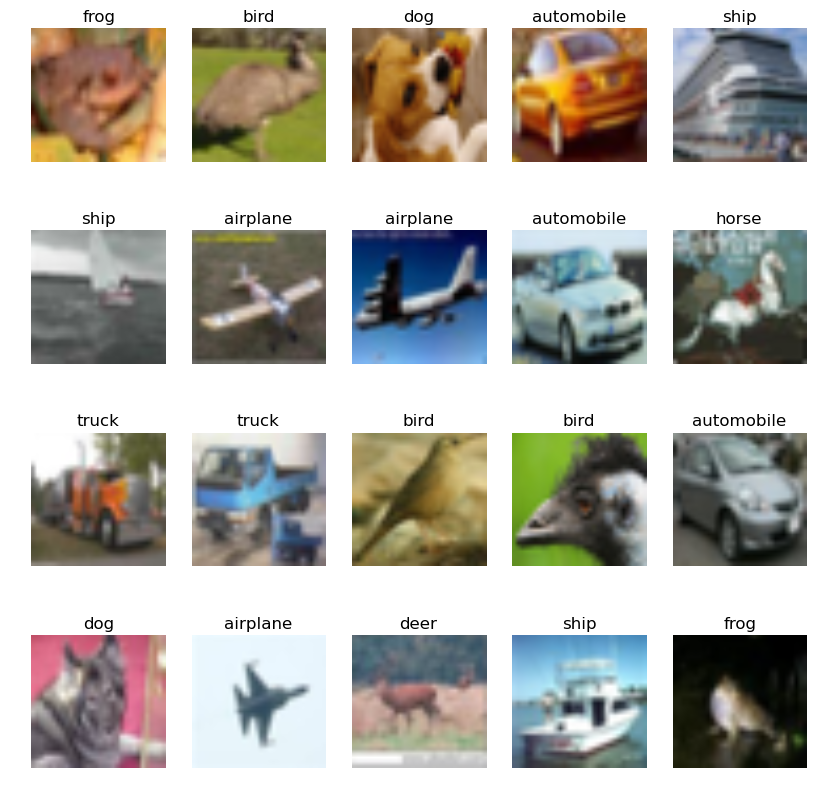

In [6]:
# Visualise some test images 
idx_list = []
for i in xrange(20):
    idx = np.random.randint(0,trainData.shape[0])
    label  = labels[np.argmax(trainLabels[idx])]; idx_list.append(idx)
    plt.subplot(4,5,i+1)
    plt.imshow(X_train[idx]*255)
    plt.title(label)
    plt.axis('off')
plt.show()

### Running the network through some test images

We run the pre-trained network through some test images to see how well it performed. 

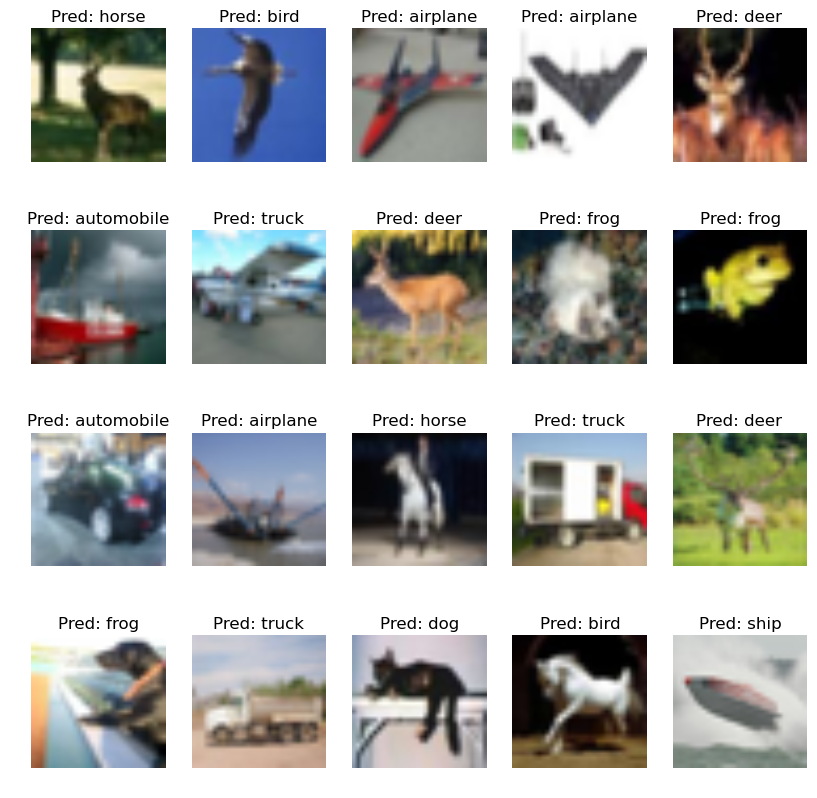

In [7]:
# Visualise some test images 
for i in xrange(20):
    idx = np.random.randint(0,testData.shape[0])
    scores = model.predict(testData[idx:idx+1])
    label  = labels[np.argmax(scores)]

    plt.subplot(4,5,i+1)
    plt.imshow(X_test[idx]*255)
    plt.title("Pred: "+label)
    plt.axis('off')
plt.show()

### Visualising the weights of the first layer

The first layer weights are the most intuitive to visualise as they directly act on the input images. They retain the ability to see geometrical structures inside the input image.

The weights are useful to visualize because well-trained networks usually display <b>nice and smooth filters</b> without any noisy patterns. Noisy patterns can be an indicator of a network that hasn’t been trained for long enough, or possibly a very low regularization strength that may have led to overfitting.

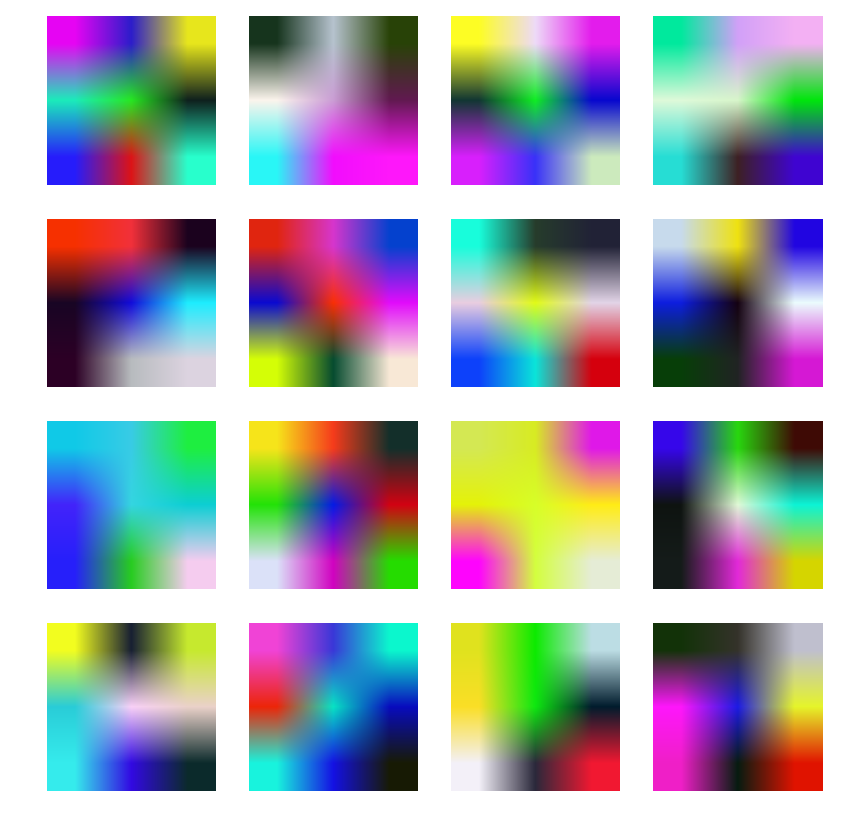

In [8]:
# extracting weights from the first Conv2D layer
first_layer = model.layers[1].get_weights()[0]

# reformatting for vis
first_layer = reformat_wts(first_layer)

# plotting the 16 kernels, each having a size (32,32,3)
for i in xrange(16):
    plt.subplot(4,4,i+1)
    plt.imshow(first_layer[i])
    plt.axis('off')
plt.show()

The weights do indeed look very smooth and geometrical, especially in row 3, column 3 where we can clearly see a geometric pattern emerge. The weights do not look noisy, they all have some form of structure within them.

### Visualising activations of the first layer

Since the weights of the first layer work directly on the input images, the output activations show a remarkable similiarity to the input image and also the geometrical features that excited that particular kernel. 

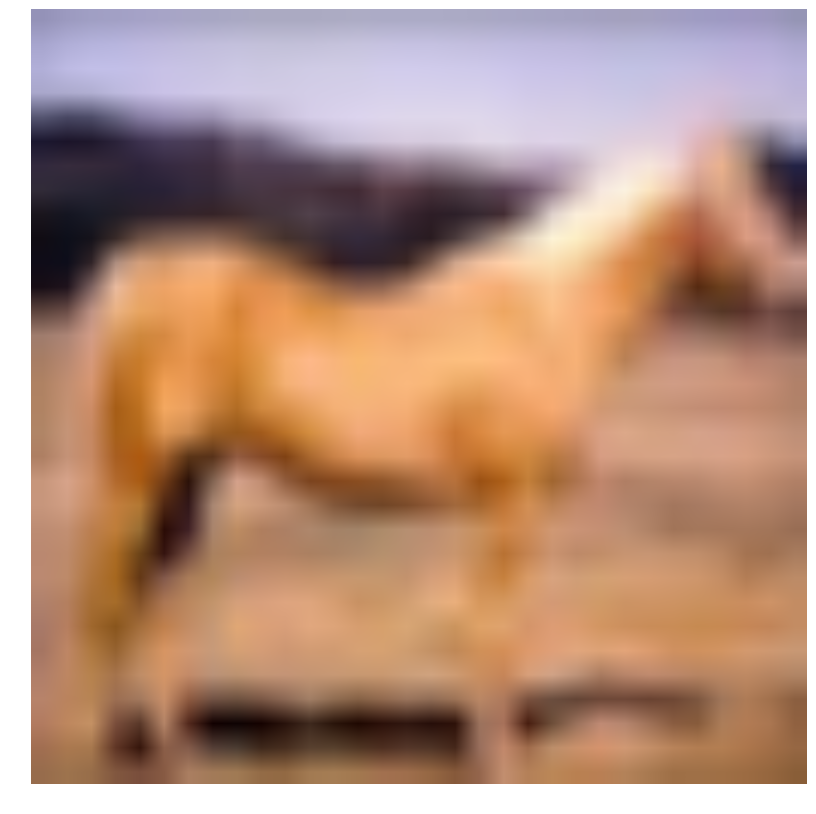

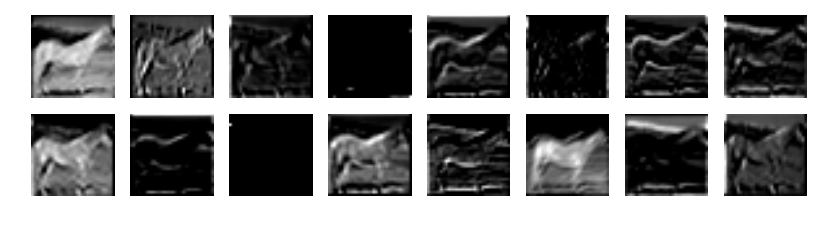

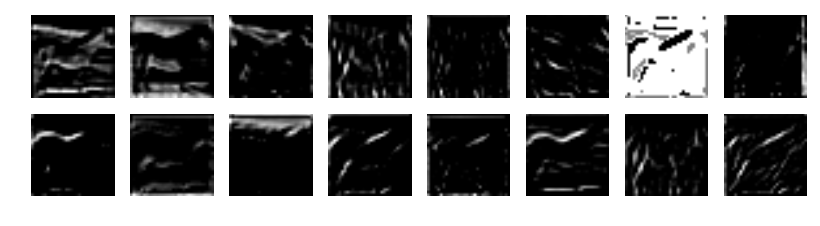

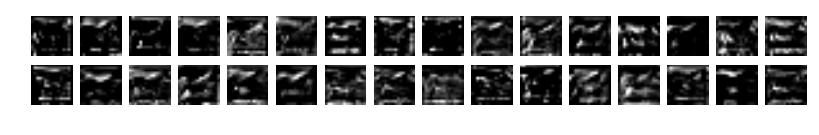

In [9]:
from keras import backend as K 

# convenience function that returns nth layer output, given input image
def generate_function(model,n):
    return K.function([model.layers[0].input], [model.layers[n].output])


idx = 700
img = testData[idx:idx+1]
plt.figure(); plt.imshow(X_test[idx]*255); plt.axis('off'); plt.show();

# displaying activations for some layers (indexed below) for input 'img'
for layer_index in [1,3,6]:
    
    # acquire activations
    fun = generate_function(model,layer_index)
    layer_activation = fun([img])[0]
    
    plt.figure(); plt.title("Layer "+str(layer_index))
    # display
    for i in xrange(layer_activation.shape[1]):
        plt.subplot(layer_activation.shape[1]/2, layer_activation.shape[1]/2, i+1)
        plt.imshow(layer_activation[0,i],'gray')
        
        plt.axis('off')
    plt.show()

As expected, only the first layer activations show some similarity to the input image, as we go deeper, the activations progressively lose link to the input image 

### Conlusion

In this iPython notebook I explored the CIFAR-10 dataset with the Keras Deep learning library. I'll probably look into why the network learned what it learned in the next notebook.